In [1]:
import os
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.1.0.dev20230705+rocm5.4.2
2.1.0.dev20230705+rocm5.4.2


In [ ]:
CAPUCHIN = os.listdir("/home/zok/joker/audio/data/Parsed_Capuchinbird_Clips")

In [32]:
CAPUCHIN = "/home/zok/joker/audio/data/Parsed_Capuchinbird_Clips/XC3776-0.wav"
NOT_CAPUCHIN = "/home/zok/joker/audio/data/Parsed_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav"

In [20]:
CAPUCHIN

'/home/zok/joker/audio/data/Parsed_Capuchinbird_Clips/XC3776-0.wav'

In [23]:
# Quering audio metadata from file
metadata = torchaudio.info(CAPUCHIN,format="wav")
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=132300, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [29]:
# Load audio file
waveform, sample_rate = torchaudio.load(CAPUCHIN)
transform = T.Resample(sample_rate, sample_rate/10)
waveform = transform(waveform)

In [30]:
# By default, dtype=torch.float32 and range is normalized within [-1.0, 1.0]
waveform.shape, sample_rate

(torch.Size([1, 13230]), 44100)

In [31]:
# Play audio
from IPython.display import Audio, display
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

play_audio(waveform, sample_rate)

In [33]:
# Plot waveform and spectrogram
import matplotlib.pyplot as plt

def _plot(waveform, sample_rate, title):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    if title == "Waveform":
      axes[c].plot(time_axis, waveform[c], linewidth=1)
      axes[c].grid(True)
    else:
      axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
  figure.suptitle(title)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Waveform")

def plot_specgram(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Spectrogram")

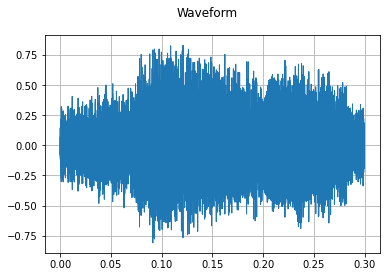

In [34]:
plot_waveform(waveform, sample_rate)

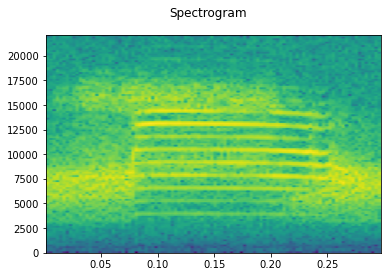

In [36]:
plot_specgram(waveform, sample_rate)

In [38]:
# RESAMPLING
# Resample an audio waveform from one frequency to another
def resampling_audio(waveform,sample_rate,resample_rate):
    #Tranform
    resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
    resampled_waveform1 = resampler(waveform)

    resampled_waveform2 = F.resample(waveform, sample_rate, resample_rate)

    play_audio(waveform, sample_rate)
    play_audio(resampled_waveform1, resample_rate)
    play_audio(resampled_waveform2, resample_rate)

#     # parameter
#     # Lowpass filter width
#     # Larger lowpass_filter_width -> sharper, more precise filter, but more computationally expensive.
#     resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=12)

#     # Rolloff
#     # Lower rolloff reduces the amount of aliasing, but it will also reduce some of the higher frequencies.
#     resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.80)

#     # Window function
#     # default = Hann window filter
#     resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
#     resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")

In [40]:
resample_rate = 16000
resampling_audio(waveform,sample_rate,resample_rate)

In [56]:
# Apply effects to file
def get_sample(waveform,sample_rate):
    effects = [
      ["lowpass", "-1", "300"], # apply single-pole lowpass filter
      ["speed", "0.8"],  # reduce the speed / # This only changes sample rate, so it is necessary to
      ["rate", f"{sample_rate}"],  # add `rate` effect with original sample rate after this.
      ["reverb", "-w"],  # Reverbration gives some dramatic feeling
    ]
    waveform, sample_rate = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effects)
    return waveform, sample_rate  

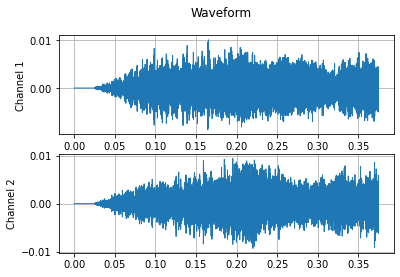

In [57]:
waveform_aug, sample_rate_aug = get_sample(waveform,sample_rate)
plot_waveform(waveform_aug, sample_rate_aug)


In [62]:
waveform_aug.shape

torch.Size([2, 16538])

In [72]:
# AUDIO FEATURE EXTRACTIONS
# Spectrogram: To get the frequency make-up of an audio signal as it varies with time, you can use Spectrogram.
def wav2specto(waveform):
    n_fft = 1024
    win_length = None
    hop_length = 512

    # define transformation
    spectrogram = T.MelSpectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
    )
    # Perform transformation
    spec = spectrogram(waveform)
    return spec

In [73]:
spec = wav2specto(waveform_aug)

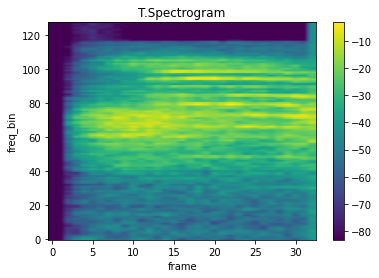

In [79]:
import librosa
# librosa is a python package for music and audio analysis.
def plot_spectrogram(spec):
  fig, axs = plt.subplots(1, 1)
  axs.set_title('T.Spectrogram')
  axs.set_ylabel('freq_bin')
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect='auto')
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


plot_spectrogram(spec[0])